# Yearly Earthquakes Prediction using LSTM

In [1]:
# import the data
import pandas as pd
df = pd.read_csv('earthquakes.csv',index_col = 'date', parse_dates = True)

In [2]:
# print top 5 rows
df.head()

,Year,earthquakes_per_year
date,,
1900-01-01,1900,13.0
1901-01-01,1901,14.0
1902-01-01,1902,8.0
1903-01-01,1903,10.0
1904-01-01,1904,16.0


In [3]:
# check for missing values
df.isna().sum()

Year                    0
earthquakes_per_year    0
dtype: int64

In [4]:
# Summary statistics
df.describe()

,Year,earthquakes_per_year
count,99.000000,99.000000
mean,1949.000000,20.020202
std,28.722813,7.263242
min,1900.000000,6.000000
25%,1924.500000,15.000000
50%,1949.000000,20.000000
75%,1973.500000,24.000000
max,1998.000000,41.000000


In [5]:
# drop the Year column from data 
df = df.drop(['Year'],axis=1)

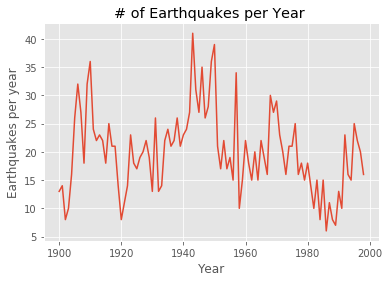

In [21]:
# plot the data
import matplotlib.pyplot as plt
plt.plot(df)
plt.xlabel('Year')
plt.ylabel("Earthquakes per year")
plt.title("# of Earthquakes per Year ")
plt.show()

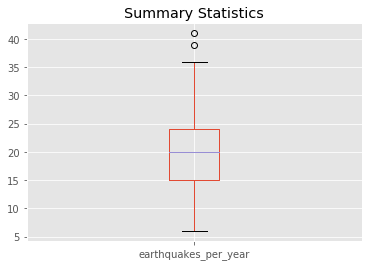

In [22]:
# summary statistics
plt.style.use('ggplot')
ax = df.boxplot()
ax.set_title('Summary Statistics')
plt.show()

In [8]:
# split data into train and test split
train_size = int(len(df) * 0.7)
test_size = (len(df) - train_size)
train, test = df[0:train_size], df[train_size:len(df)] 

In [9]:
# import MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
data = df['earthquakes_per_year'].values
data = data.reshape(-1,1)

In [10]:
# fit MinMax Scaler in train and test
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [11]:
# preprocess the input for LSTM
import numpy as np
def data_preprocess(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y) 

In [12]:
X_train, y_train = data_preprocess(train, look_back=1)
X_test, y_test = data_preprocess(test, look_back=1)

In [13]:
# Reshaping the data into 3-D 
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

In [14]:
# import necessary layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [15]:
# model
model = Sequential()
model.add(LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [16]:
# fit the model
history  = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor = 'val_loss',patience =20), 
                                                                                     ModelCheckpoint("best.model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')])

Epoch 1/100
1/3 [=========>....................] - ETA: 0s - loss: 0.1973
Epoch 00001: val_loss improved from inf to 0.08090, saving model to best.model.hdf5
3/3 [==============================] - 1s 372ms/step - loss: 0.2023 - val_loss: 0.0809
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.1496
Epoch 00002: val_loss improved from 0.08090 to 0.06902, saving model to best.model.hdf5
3/3 [==============================] - 0s 64ms/step - loss: 0.1787 - val_loss: 0.0690
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.1480
Epoch 00003: val_loss improved from 0.06902 to 0.05800, saving model to best.model.hdf5
3/3 [==============================] - 0s 77ms/step - loss: 0.1612 - val_loss: 0.0580
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.1483
Epoch 00004: val_loss improved from 0.05800 to 0.04805, saving model to best.model.hdf5
3/3 [==============================] - 0s 104ms/step - loss: 0.1378 - val_loss: 0.0481
Epoch 5/10

In [17]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [18]:
# Compare RMSE for train and test data
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Root Mean Squared Error: 6.370768
Test Root Mean Squared Error: 5.8465495


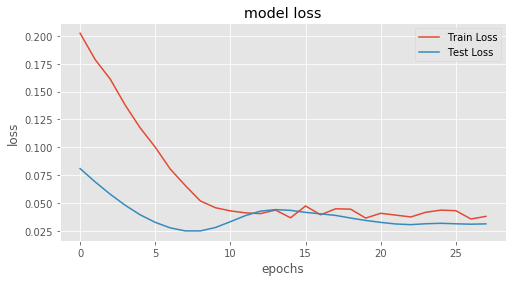

In [19]:
# plot for model loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

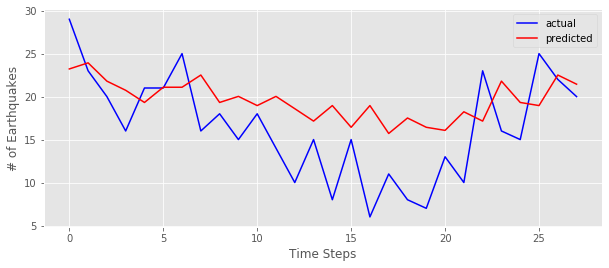

In [20]:
# plot for actual vs predicted values 
plt.figure(figsize=(10,4))
plt.plot(y_test[0], color='blue', label ='actual')
plt.plot(test_predict, color ='red', label ='predicted')
plt.xlabel('Time Steps')
plt.ylabel('# of Earthquakes')
plt.legend()
plt.show()